<a href="https://colab.research.google.com/github/kosmasrio0411/PCD_Assignment02/blob/main/PCD_Assignment02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tugas 2 Pengolahan Citra Digital
##Image Enhancement

Nama: Kosmas Rio Legowo

NIM: 23/512012/PA/21863

##Load Citra


In [ ]:
# --- Install & import ---
!pip install -q gdown
import os, zipfile, gdown

url = f"https://drive.google.com/uc?id=1O3J4EUTc4BJpsI1thxrktoIzMO0X3MLK"
zip_path = "/content/images.zip"
gdown.download(url, zip_path, quiet=False)

extract_dir = "/content/data"
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, "r") as zf:
    zf.extractall(extract_dir)

# --- Langsung set path (asumsi file ada di root ZIP) ---
gelap = f"{extract_dir}/gelap.jpg"
terang = f"{extract_dir}/terang.jpg"
blur  = f"{extract_dir}/blur.jpg"
lowc  = f"{extract_dir}/low_contrast.jpg"
sp    = f"{extract_dir}/noisy_saltpepper.jpg"


Downloading...
From: https://drive.google.com/uc?id=1O3J4EUTc4BJpsI1thxrktoIzMO0X3MLK
To: /content/images.zip
100%|██████████| 424k/424k [00:00<00:00, 90.9MB/s]


##Function Setup

In [ ]:
import numpy as np
import cv2 as cv   # hanya untuk read/write & konversi ke grayscale
import matplotlib.pyplot as plt

# ---------- I/O Utilities ----------
def read_image_gray_cv(path):
    """
    Load image pakai OpenCV -> grayscale 2D float32 [0,1].
    """
    img = cv.imread(path, cv.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Cannot read image: {path}")

    # Buang alpha jika ada
    if img.ndim == 3 and img.shape[-1] == 4:
        img = img[:, :, :3]

    # Jika RGB/BGR, ubah ke GRAY
    if img.ndim == 3 and img.shape[-1] == 3:
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    img = img.astype(np.float32)
    if img.max() > 1.0:
        img = img / 255.0
    if img.max() <= 0.0:
        img = np.zeros_like(img, dtype=np.float32)
    return img  # (H,W) float32 [0,1]

def save_image_gray_cv(path, img):
    """
    Save grayscale float [0,1] pakai OpenCV.
    """
    img8 = np.clip(img, 0.0, 1.0)
    img8 = (img8 * 255.0 + 0.5).astype(np.uint8)
    cv.imwrite(path, img8)

##Function Enhancement baik based on Filtering maupun Pixel

In [ ]:
# ---------- Pixel Transforms (grayscale) ----------
def negative(img):
    return 1.0 - img

def log_transform(img, c=1.0):
    # s = c * log(1 + r) (dinormalisasi relatif log(2))
    return np.clip(np.log1p(np.clip(img,0,1)) * (c / np.log(2.0)), 0, 1)

def gamma_correction(img, gamma=0.8, c=1.0):
    return np.clip(c * np.power(np.clip(img,0,1), gamma), 0, 1)

def contrast_stretch(img, in_range=None, out_range=(0.0,1.0)):
    if in_range is None:
        low, high = np.percentile(img, [1, 99])
    else:
        low, high = in_range
    a, b = out_range
    if high - low < 1e-6:
        return np.clip(img, a, b)
    out = (img - low) * (b - a) / (high - low) + a
    return np.clip(out, a, b)

def gray_level_slicing(img, a, b, high=1.0, low=0.0, preserve=False):
    out = img.copy()
    mask = (img >= a) & (img <= b)
    out[mask] = high
    if not preserve:
        out[~mask] = low
    return np.clip(out, 0, 1)

# ---------- Histogram Equalization (grayscale) ----------
def hist_equalize_gray(gray):
    g = np.clip(gray, 0, 1)
    hist, _ = np.histogram(g.flatten(), bins=256, range=(0.0,1.0))
    cdf = np.cumsum(hist).astype(np.float64)
    cdf /= max(1, cdf[-1])
    idx = np.minimum((g * 255).astype(np.int32), 255)
    out = cdf[idx]
    return out.astype(np.float32)

# ---------- Convolution (grayscale) ----------
def _pad_reflect(x, pad):
    if pad == 0: return x
    return np.pad(x, ((pad,pad),(pad,pad)), mode='reflect')

def convolve2d_gray(img, kernel, padding='reflect'):
    """
    img: (H,W) float
    kernel: (k,k) float, k ganjil
    """
    k = kernel.shape[0]
    assert kernel.shape[0] == kernel.shape[1] and k % 2 == 1
    pad = k // 2
    src = _pad_reflect(img, pad) if padding == 'reflect' else np.pad(img, ((pad,pad),(pad,pad)), mode='constant')
    H, W = img.shape
    out = np.zeros_like(img, dtype=np.float32)
    ker = kernel[::-1, ::-1]  # flip untuk konvolusi
    for i in range(H):
        for j in range(W):
            patch = src[i:i+k, j:j+k]
            out[i,j] = np.sum(patch * ker, dtype=np.float64)
    return out

# ---------- Smoothing & Gaussian ----------
def box_filter(img, ksize=3):
    k = np.ones((ksize,ksize), dtype=np.float32) / (ksize*ksize)
    return convolve2d_gray(img, k)

def gaussian_kernel(ksize=5, sigma=1.0):
    ax = np.arange(-(ksize//2), ksize//2 + 1)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2*sigma**2))
    kernel /= np.sum(kernel)
    return kernel.astype(np.float32)

def gaussian_blur(img, ksize=5, sigma=1.0):
    k = gaussian_kernel(ksize, sigma)
    return convolve2d_gray(img, k)

# ---------- Median Filter ----------
def median_filter_gray(img, ksize=3):
    pad = ksize // 2
    src = _pad_reflect(img, pad)
    H, W = img.shape
    out = np.zeros_like(img)
    for i in range(H):
        for j in range(W):
            patch = src[i:i+ksize, j:j+ksize]
            out[i,j] = np.median(patch)
    return out

# ---------- Sharpening (Laplacian & Unsharp) ----------
def laplacian_filter(img):
    k = np.array([[0, 1, 0],
                  [1,-4, 1],
                  [0, 1, 0]], dtype=np.float32)
    return convolve2d_gray(img, k)

def unsharp_mask(img, ksize=5, sigma=1.0, amount=1.0):
    blur = gaussian_blur(img, ksize, sigma)
    detail = img - blur
    sharp = np.clip(img + amount * detail, 0, 1)
    return sharp

##Function Enhance by Case

In [ ]:
def enhance_dark(gray):
    """
    Gambar gelap: gamma<1 untuk mencerahkan + stretching ringan.
    """
    out = gamma_correction(gray, gamma=0.7)
    out = contrast_stretch(out)
    return out

def enhance_bright(gray):
    """
    Gambar terlalu terang: gamma>1 untuk menekan highlight + stretching.
    """
    out = gamma_correction(gray, gamma=1.4)
    out = contrast_stretch(out)
    return out

def enhance_low_contrast(gray):
    """
    Low-contrast: histogram equalization (global).
    """
    out = hist_equalize_gray(gray)
    return out

def enhance_blurred(gray, ksize=5, sigma=1.2, amount=1.5):
    """
    Blurred: unsharp masking.
    """
    out = unsharp_mask(gray, ksize=ksize, sigma=sigma, amount=amount)
    return out

def enhance_noisy_saltpepper(gray, ksize=3):
    """
    Noise salt & pepper: median filter + slight stretch.
    """
    out = median_filter_gray(gray, ksize=ksize)
    out = contrast_stretch(out)
    return out

##Mencoba Enhancement by Case

###Enhancement Gambar Blur

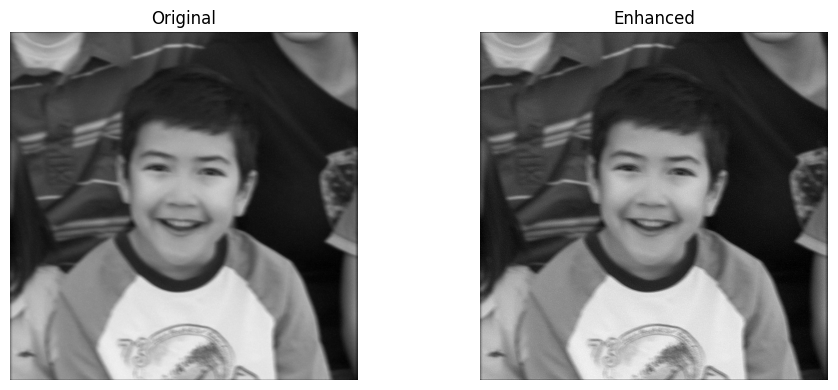

In [ ]:
g = read_image_gray_cv(blur)

#Pilih kasus secara manual:
out = enhance_blurred(g)

#Tampilkan citra asli & enhanced berdampingan
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(g, cmap='gray', vmin=0, vmax=1)
plt.title("Original")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(out, cmap='gray', vmin=0, vmax=1)
plt.title("Enhanced")
plt.axis('off')

plt.tight_layout()
plt.show()

###Enhancement Gambar Gelap

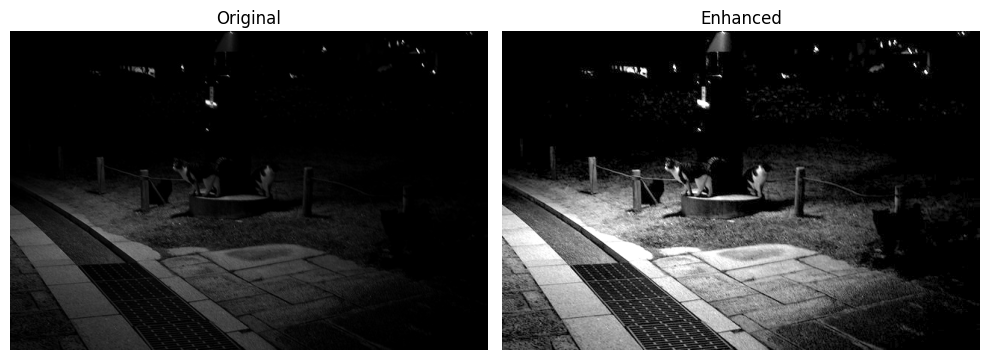

In [ ]:
g = read_image_gray_cv(gelap)

#Pilih kasus secara manual:
out = enhance_dark(g)

#Tampilkan citra asli & enhanced berdampingan
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(g, cmap='gray', vmin=0, vmax=1)
plt.title("Original")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(out, cmap='gray', vmin=0, vmax=1)
plt.title("Enhanced")
plt.axis('off')

plt.tight_layout()
plt.show()

###Enhancement Gambar Terang

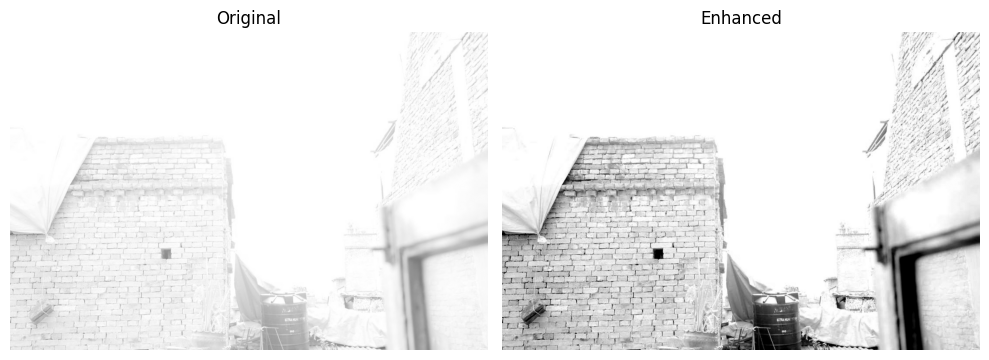

In [ ]:
g = read_image_gray_cv(terang)

#Pilih kasus secara manual:
out = enhance_bright(g)

#Tampilkan citra asli & enhanced berdampingan
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(g, cmap='gray', vmin=0, vmax=1)
plt.title("Original")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(out, cmap='gray', vmin=0, vmax=1)
plt.title("Enhanced")
plt.axis('off')

plt.tight_layout()
plt.show()

###Enhancement Low-contrast Image

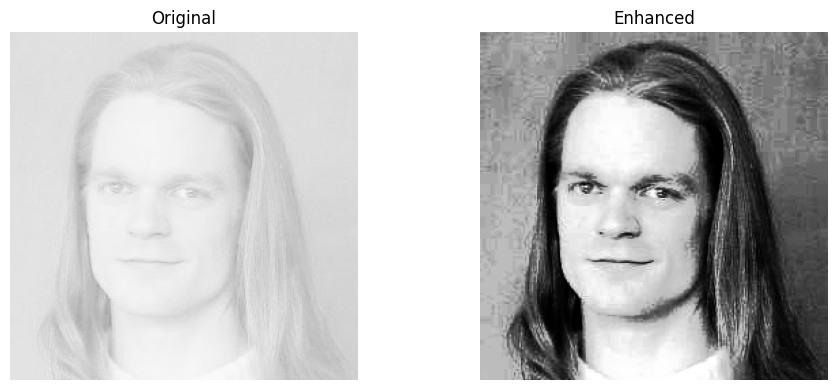

In [ ]:
g = read_image_gray_cv(lowc)

#Pilih kasus secara manual:
out = enhance_low_contrast(g)

#Tampilkan citra asli & enhanced berdampingan
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(g, cmap='gray', vmin=0, vmax=1)
plt.title("Original")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(out, cmap='gray', vmin=0, vmax=1)
plt.title("Enhanced")
plt.axis('off')

plt.tight_layout()
plt.show()

###Enhancement Noise Salt and Pepper

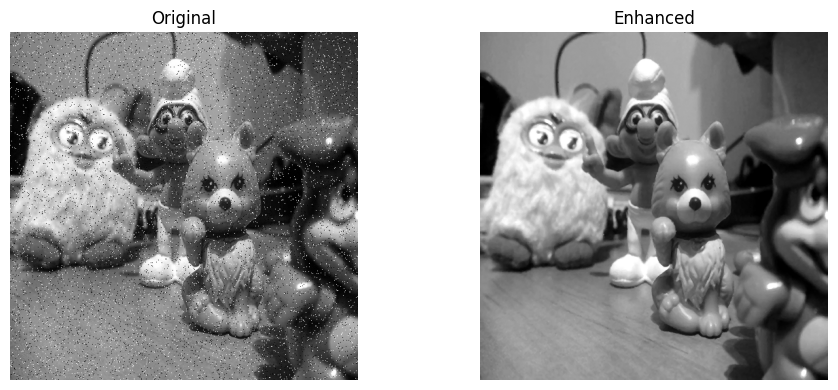

In [ ]:
g = read_image_gray_cv(sp)

#Pilih kasus secara manual:
out = enhance_noisy_saltpepper(g)

#Tampilkan citra asli & enhanced berdampingan
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(g, cmap='gray', vmin=0, vmax=1)
plt.title("Original")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(out, cmap='gray', vmin=0, vmax=1)
plt.title("Enhanced")
plt.axis('off')

plt.tight_layout()
plt.show()

##Enhancement Otomatis sesuai kondisi citra

In [ ]:
# ---------- Diagnostics ----------
def laplacian_variance(gray):
    lap = laplacian_filter(gray)
    return float(np.var(lap))

def estimate_impulse_noise(gray, ksize=3, tail=0.04, diff_thresh=0.25):

    g = np.clip(gray, 0, 1).astype(np.float32)
    med = median_filter_gray(g, ksize)       # median lokal (from scratch)
    diff = np.abs(g - med)

    tail_mask = (g < tail) | (g > 1.0 - tail)   # hanya ekor
    impulsive = (diff > diff_thresh) & tail_mask

    # skor = proporsi piksel impulsif
    return float(np.mean(impulsive))


def quick_classify_and_enhance(gray):
    g = np.clip(gray, 0, 1).astype(np.float32)

    mean = float(np.mean(g))
    std  = float(np.std(g))
    rng  = float(np.max(g) - np.min(g))
    p1, p5, p95, p99 = np.percentile(g, [1, 5, 95, 99])
    lapv = laplacian_variance(g)
    spn  = estimate_impulse_noise(g, ksize=3, tail=0.04, diff_thresh=0.25)

    #Global exposure (supaya highlight clipped tidak disangka noise impuls)
    if mean < 0.35:
        return enhance_dark(g), "dark"
    if mean > 0.65:
        return enhance_bright(g), "bright"

    # Noise impuls (lebih ketat, ambang lebih kecil)
    if spn > 0.015 and (p99 > 0.9 or p1 < 0.1):
        return enhance_noisy_saltpepper(g), "noisy_saltpepper"

    #Low-contrast menggunakan deviasi standar + rentang persentil untuk robust
    if std < 0.10 or (p95 - p5) < 0.5:
        return enhance_low_contrast(g), "low_contrast"

    # Blur (gunakan threshold sedikit adaptif terhadap kontras)
    blur_thresh = 0.002 if std >= 0.12 else 0.0015
    if lapv < blur_thresh:
        return enhance_blurred(g), "blurred"

    # 5) Default: sedikit stretching
    return contrast_stretch(g), "default_stretch"

Chosen case: noisy_saltpepper


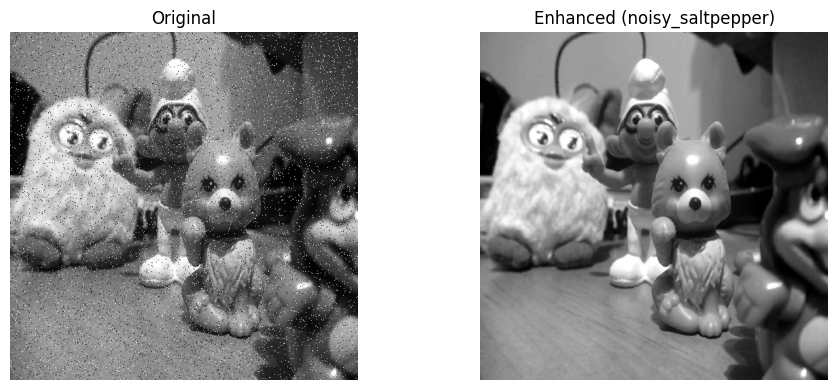

In [ ]:
g = read_image_gray_cv(sp)

#Klasifikasi + enhance
out, label = quick_classify_and_enhance(g)
print("Chosen case:", label)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(g, cmap='gray', vmin=0, vmax=1)
plt.title("Original")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(out, cmap='gray', vmin=0, vmax=1)
plt.title(f"Enhanced ({label})")
plt.axis('off')

plt.tight_layout()
plt.show()

Chosen case: bright


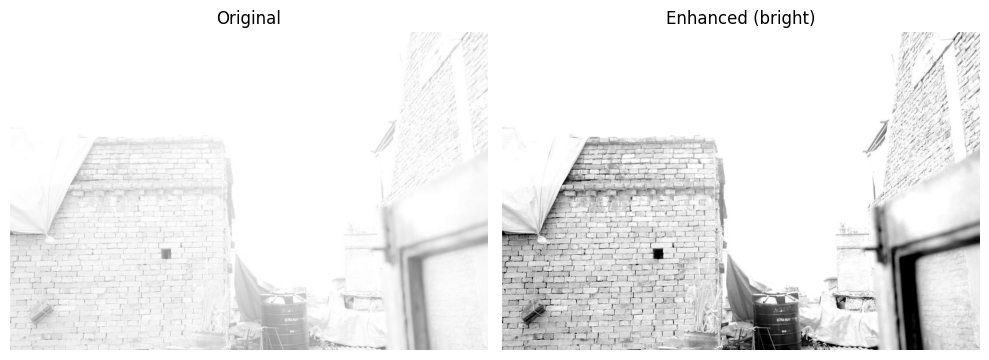

In [ ]:
g = read_image_gray_cv(terang)

#Klasifikasi + enhance
out, label = quick_classify_and_enhance(g)
print("Chosen case:", label)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(g, cmap='gray', vmin=0, vmax=1)
plt.title("Original")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(out, cmap='gray', vmin=0, vmax=1)
plt.title(f"Enhanced ({label})")
plt.axis('off')

plt.tight_layout()
plt.show()

##Kesimpulan

Image enhancement menjadi penting agar informasi visual lebih mudah dibaca dan diproses. Teknik seperti contrast stretching, gamma correction, histogram equalization, smoothing/median, dan unsharp masking membantu:

* menormalkan eksposur dan menaikkan kontras,

* mengurangi noise tanpa menghilangkan detail,

* memulihkan ketajaman pada citra buram,

* menyiapkan kualitas gambar yang konsisten

Tujuannya image enhancement bukan mengubah isi, melainkan memperjelas informasi pada citra sehingga dapat diproses lebih lanjut baik untuk segmentasi, feature extraction dan analisis lebih lanjut.